--- 포트폴리오 백테스팅 (리밸런싱 적용) 시뮬레이션 시작 ---

--- 'Max Calmar Ratio' 모델 시뮬레이션 시작 ---


C:\Users\012oov\AppData\Local\Temp\ipykernel_27536\773279982.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


Total rebalances: 14
  - 최종 가치: $598,928,440.51, CAGR: 26.29%, MDD: -46.23%, Sharpe: 1.09, Calmar: 0.57

--- 'Risk Parity' 모델 시뮬레이션 시작 ---


C:\Users\012oov\AppData\Local\Temp\ipykernel_27536\773279982.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


Total rebalances: 2
  - 최종 가치: $168,459,279.93, CAGR: 7.04%, MDD: -15.91%, Sharpe: 0.98, Calmar: 0.44

--- 'Minimum Variance' 모델 시뮬레이션 시작 ---


C:\Users\012oov\AppData\Local\Temp\ipykernel_27536\773279982.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


Total rebalances: 0
  - 최종 가치: $116,061,490.92, CAGR: 1.96%, MDD: -5.39%, Sharpe: 1.18, Calmar: 0.36

--- 'Daily (30% Cap)' 모델 시뮬레이션 시작 ---


C:\Users\012oov\AppData\Local\Temp\ipykernel_27536\773279982.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


Total rebalances: 6
  - 최종 가치: $296,634,806.18, CAGR: 15.23%, MDD: -26.40%, Sharpe: 1.24, Calmar: 0.58

--- 'Target Return (18%)' 모델 시뮬레이션 시작 ---


C:\Users\012oov\AppData\Local\Temp\ipykernel_27536\773279982.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)


Total rebalances: 10
  - 최종 가치: $413,622,826.23, CAGR: 20.34%, MDD: -33.14%, Sharpe: 1.29, Calmar: 0.61

--- 'Benchmark (Spy)' 모델 시뮬레이션 시작 ---
  - 최종 가치: $273,756,642.92, CAGR: 14.04%, MDD: -33.72%, Sharpe: 0.77, Calmar: 0.42

--- 'Benchmark (Btc-Usd)' 모델 시뮬레이션 시작 ---
  - 최종 가치: $1,653,442,981.61, CAGR: 45.63%, MDD: -83.04%, Sharpe: 0.90, Calmar: 0.55


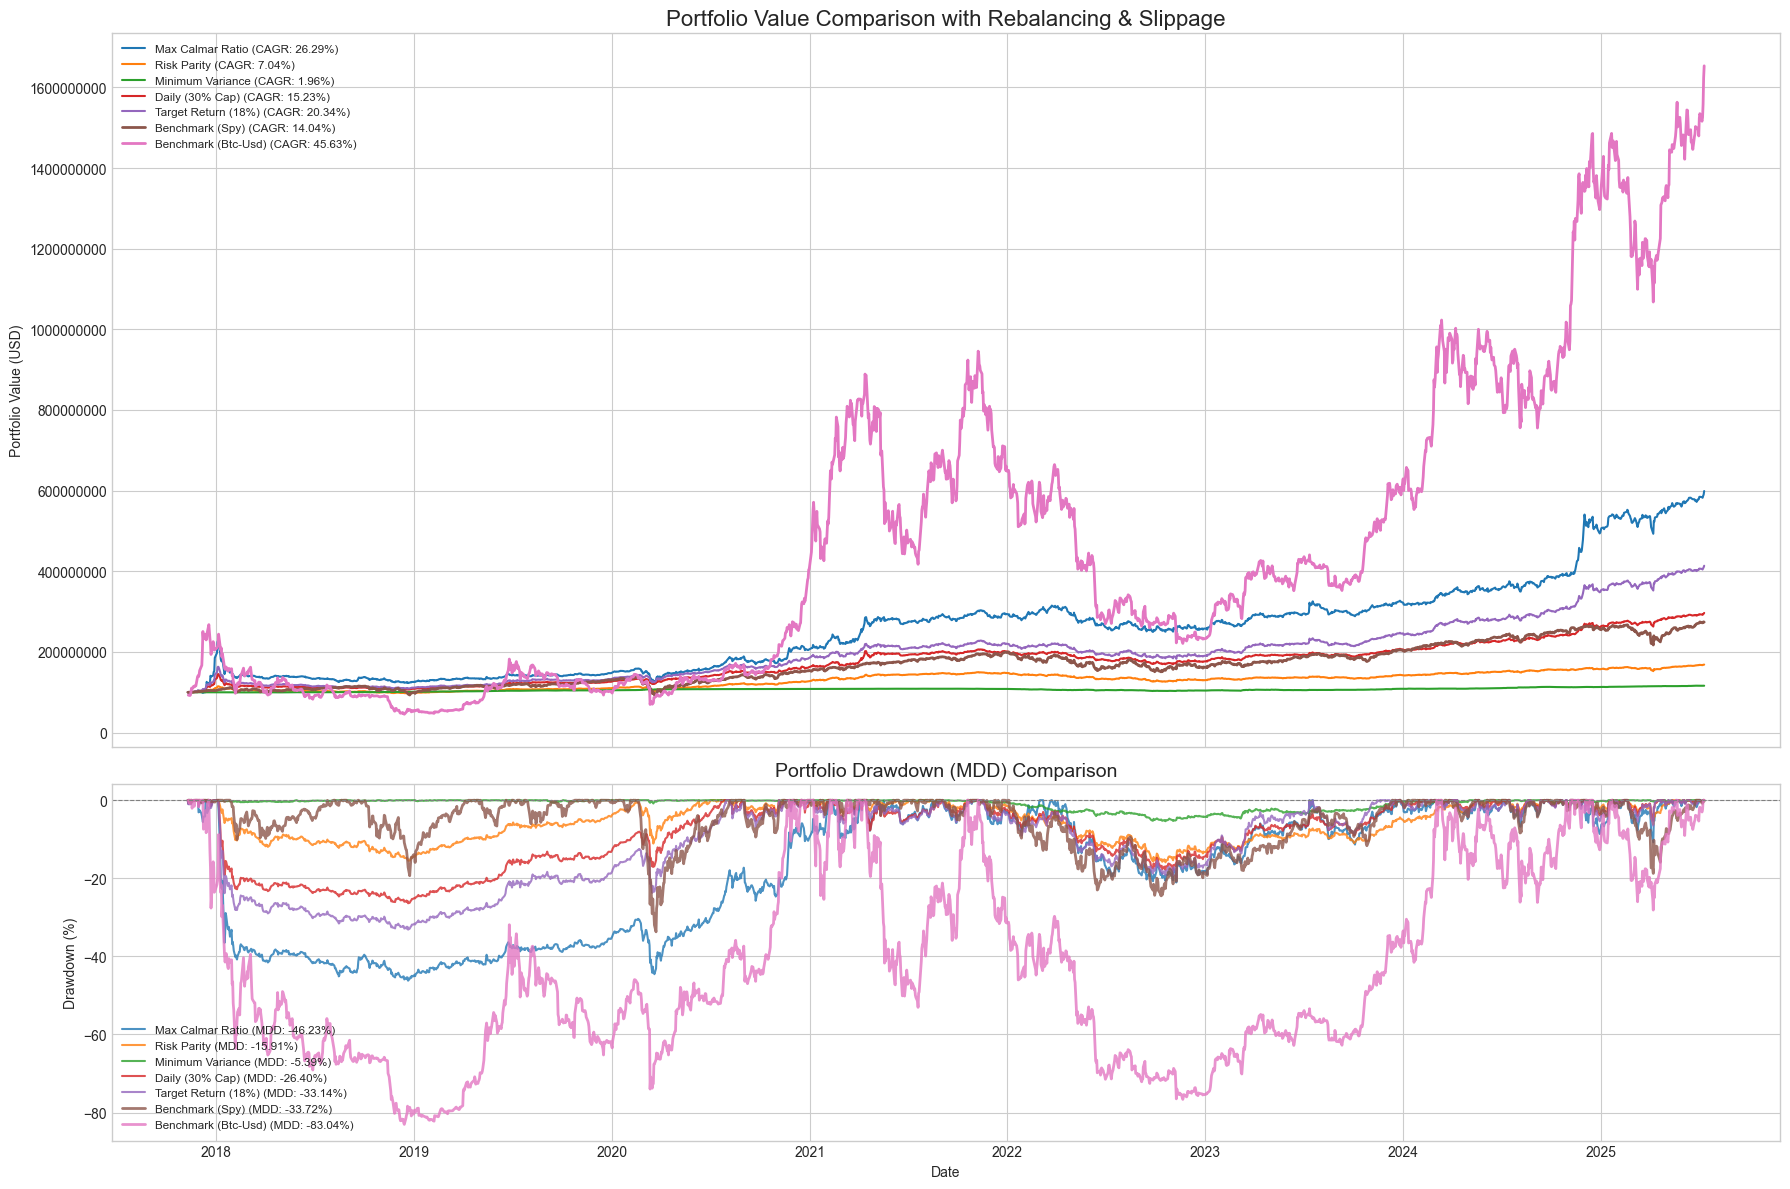

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

def run_rebalancing_simulation(prices_df, target_weights, initial_investment, frequency, threshold, slippage):
    """리밸런싱과 슬리피지를 적용하여 포트폴리오 가치를 시뮬레이션합니다."""
    target_weights = pd.Series(target_weights, index=prices_df.columns)
    portfolio_log = pd.DataFrame(index=prices_df.index, columns=['total_value'] + list(prices_df.columns))
    portfolio_log.iloc[0] = [initial_investment] + list(initial_investment * target_weights)
    
    rebal_check_dates = pd.to_datetime(prices_df.resample(frequency).last().index)
    rebalance_count = 0

    for i in range(1, len(prices_df)):
        prev_date, curr_date = prices_df.index[i-1], prices_df.index[i]
        daily_returns = prices_df.loc[curr_date] / prices_df.loc[prev_date]
        current_asset_values = portfolio_log.loc[prev_date, prices_df.columns] * daily_returns
        current_total_value = current_asset_values.sum()
        
        if curr_date in rebal_check_dates:
            current_weights = current_asset_values / current_total_value
            if np.abs(current_weights - target_weights).max() > threshold:
                rebalance_count += 1
                turnover = np.abs(current_total_value * target_weights - current_asset_values).sum() / 2
                cost = turnover * slippage
                current_total_value -= cost
                current_asset_values = current_total_value * target_weights

        portfolio_log.loc[curr_date] = [current_total_value] + list(current_asset_values)
        
    print(f"Total rebalances: {rebalance_count}")
    return portfolio_log['total_value'].astype(float)

def calculate_mdd(portfolio_value_series):
    """MDD와 Drawdown 시계열을 계산합니다."""
    peak = portfolio_value_series.expanding(min_periods=1).max()
    drawdown = (portfolio_value_series / peak) - 1.0
    return drawdown.min(), drawdown

def calculate_cagr(portfolio_value_series):
    """연평균 복합 성장률 (CAGR)을 계산합니다."""
    total_years = (portfolio_value_series.index[-1] - portfolio_value_series.index[0]).days / 365.25
    return (portfolio_value_series.iloc[-1] / portfolio_value_series.iloc[0])**(1/total_years) - 1 if total_years > 0 else 0

def calculate_sharpe_ratio(portfolio_value_series, risk_free_rate_annual):
    """연간 샤프 비율을 계산합니다."""
    daily_returns = portfolio_value_series.pct_change().dropna()
    if daily_returns.std() == 0: return 0
    excess_returns = daily_returns - ((1 + risk_free_rate_annual)**(1/252) - 1)
    return (excess_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))

def calculate_calmar_ratio(cagr, mdd):
    """칼마 지수를 계산합니다."""
    return cagr / abs(mdd) if mdd < 0 else 0

def format_model_name(sheet_name):
    """Excel 시트 이름을 그래프에 표시할 이름으로 변환합니다."""
    name = sheet_name.replace('_weights', '')
    if 'target_return' in name: return f"Target Return ({name.split('_')[-1]}%)"
    name_map = {
        'max_calmar': 'Max Calmar Ratio',
        'risk_parity': 'Risk Parity',
        'min_variance': 'Minimum Variance',
        'daily_30_cap': 'Daily (30% Cap)',
        'daily_max_sharpe': 'Daily (Max Sharpe)',
        'weekly_max_sharpe': 'Weekly (Max Sharpe)',
        'monthly_max_sharpe': 'Monthly (Max Sharpe)',
    }
    return name_map.get(name, name.replace('_', ' ').title())

# --- 메인 실행 흐름 ---
if __name__ == "__main__":
    # --- 경로 설정 ---
    try:
        PROJECT_ROOT = Path(__file__).resolve().parent.parent
    except NameError:
        PROJECT_ROOT = Path.cwd().parent
    DATA_DIR = PROJECT_ROOT / "Data"
    RESULTS_DIR = PROJECT_ROOT / "Results"
    DOWNLOADED_DATA_PATH = DATA_DIR / "Raw data" / "downloaded_stock_prices.csv"
    OPTIMIZED_WEIGHTS_EXCEL_PATH = RESULTS_DIR / "optimized_weights_all_periods.xlsx"

    # --- 시뮬레이션 상세 설정 ---
    INITIAL_INVESTMENT_USD = 100_000_000
    RISK_FREE_RATE_ANNUAL = 0.00
    SLIPPAGE_PCT = 0.001
    REBALANCING_FREQUENCY = 'M'
    REBALANCING_THRESHOLD = 0.05
    
    print("--- 포트폴리오 백테스팅 (리밸런싱 적용) 시뮬레이션 시작 ---")

    try:
        price_data = pd.read_csv(DOWNLOADED_DATA_PATH, index_col=0, parse_dates=True)
        all_weights_dict = pd.read_excel(OPTIMIZED_WEIGHTS_EXCEL_PATH, sheet_name=None)
    except FileNotFoundError as e:
        print(f"오류: 필수 파일 로드 실패 - {e}")
        exit()

    portfolio_results = {}
    
    # 1. 모든 최적화 모델 및 벤치마크 성과 계산
    models_to_run = {**all_weights_dict, 'Benchmark (SPY)': 'SPY', 'Benchmark (BTC-USD)': 'BTC-USD'}
    for sheet_name, data in models_to_run.items():
        model_name = format_model_name(sheet_name)
        print(f"\n--- '{model_name}' 모델 시뮬레이션 시작 ---")
        
        if isinstance(data, pd.DataFrame): # 최적화 모델
            tickers = data['Ticker'].tolist()
            weights = data['Optimal_Weight'].values
            model_price_data = price_data[tickers].dropna()
            portfolio_value = run_rebalancing_simulation(model_price_data, weights, INITIAL_INVESTMENT_USD, REBALANCING_FREQUENCY, REBALANCING_THRESHOLD, SLIPPAGE_PCT)
        else: # 벤치마크
            bm_price_data = price_data[[data]].dropna()
            bm_returns = bm_price_data.pct_change().dropna()
            portfolio_value = (INITIAL_INVESTMENT_USD * (1 + bm_returns).cumprod()).iloc[:, 0]

        mdd, drawdown = calculate_mdd(portfolio_value)
        cagr = calculate_cagr(portfolio_value)
        sharpe = calculate_sharpe_ratio(portfolio_value, RISK_FREE_RATE_ANNUAL)
        calmar = calculate_calmar_ratio(cagr, mdd)
        
        portfolio_results[model_name] = {'value': portfolio_value, 'cagr': cagr, 'mdd': mdd, 'sharpe': sharpe, 'calmar': calmar, 'drawdown': drawdown}
        print(f"  - 최종 가치: ${portfolio_value.iloc[-1]:,.2f}, CAGR: {cagr*100:.2f}%, MDD: {mdd*100:.2f}%, Sharpe: {sharpe:.2f}, Calmar: {calmar:.2f}")

    # 2. 시각화
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    colors = plt.colormaps['tab10'].colors
    
    for i, (name, data) in enumerate(portfolio_results.items()):
        color = colors[i % len(colors)]
        # 포트폴리오 가치
        ax1.plot(data['value'].index, data['value'], label=f"{name} (CAGR: {data['cagr']*100:.2f}%)", color=color, linewidth=2 if 'Benchmark' in name else 1.5)
        # MDD
        ax2.plot(data['drawdown'].index, data['drawdown'] * 100, label=f"{name} (MDD: {data['mdd']*100:.2f}%)", color=color, alpha=0.8, linewidth=2 if 'Benchmark' in name else 1.5)

    ax1.set_title('Portfolio Value Comparison with Rebalancing & Slippage', fontsize=16)
    ax1.set_ylabel('Portfolio Value (USD)')
    ax1.legend(loc='upper left', fontsize='small')
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.grid(True)
    
    ax2.set_title('Portfolio Drawdown (MDD) Comparison', fontsize=14)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown (%)')
    ax2.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax2.legend(loc='lower left', fontsize='small')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
